## Projet BiML : Partie GNN

L'objectif du projet est d'écrire un rapport qui décrit la recherche d'une méthode adaptée basée sur les GNN pour répondre à une question de recherche. Ce notebook contient le code relatif à cette recherche.

La question que nous cherchons à résoudre est la classification consistant à prédire l'une des propriétés des noeuds dans notre cas nous tenterons de prédire le pays.

### Import des bibliothèques

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
import torch_geometric
import torch_geometric.transforms as T
import seaborn as sns
import geopandas
import geodatasets
import warnings

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

### Chargement des données

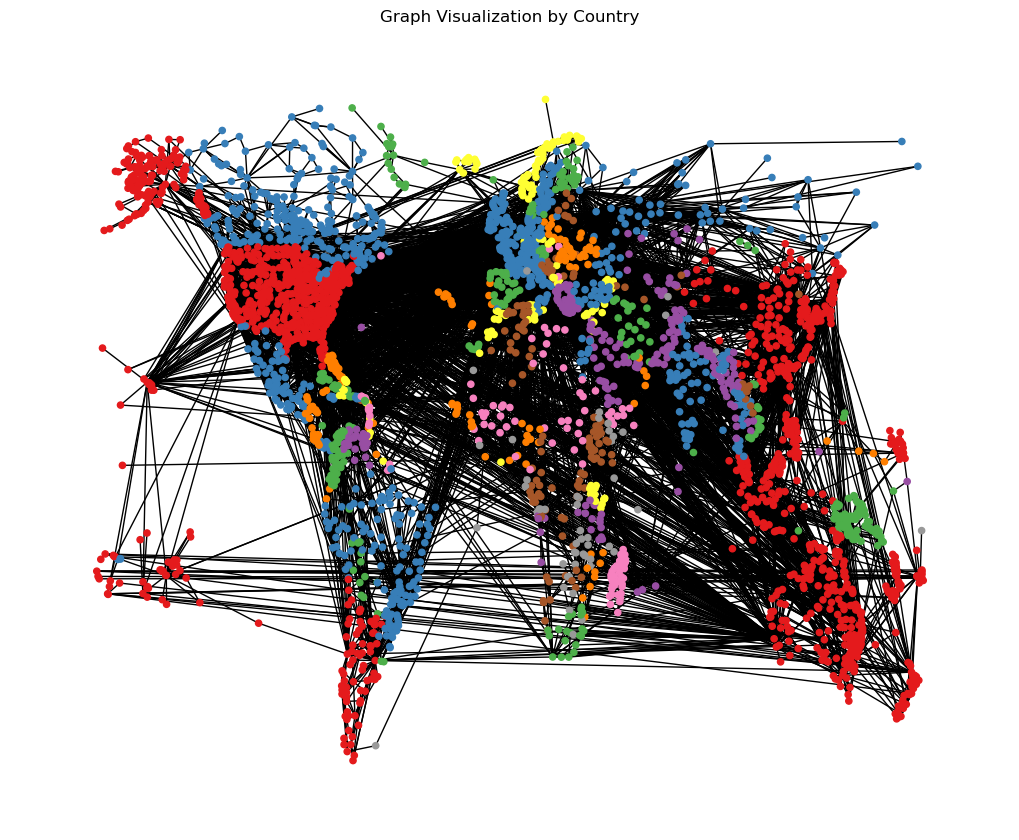

In [2]:
G = nx.read_graphml("airportsAndCoordAndPop.graphml")

country_colors = {}
for node, attrs in G.nodes(data=True):
    country = attrs['country']
    if country not in country_colors:
        country_colors[country] = len(country_colors) / 10

node_colors = [country_colors[attrs['country']] for _, attrs in G.nodes(data=True)]

edge_colors = [country_colors[G.nodes[n1]['country']] for n1, n2 in G.edges()]

plt.figure(figsize=(10, 8))
pos = {node: (attrs['lon'], attrs['lat']) for node, attrs in G.nodes(data=True)}
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=20, font_size=10, cmap=plt.cm.Set1)
plt.title('Graph Visualization by Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

### Préparation des données

In [3]:
G.nodes(data=True)

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Anaa'}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Hao Island'}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Papeete'}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Gambier Island'}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Makemo'}, '5': {'lon': 174.79166666666666, 'lat': -37.00805555555556, 'population': 417910, 'country': 'NEW_ZEALAND', 'city_name': 'Auckland'}, '6': {'lon': -139.03333333333333, 'lat': -9.8, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Atuona'}, '7': {'lon': -151.75, 'lat': -16.45, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 

#### Conversion des données géospatiales (latitude et longitude) en données 3D

$x = cos(lat) * cos(lon)\newline$
$y = cos(lat) * sin(lon)\newline$
$z = sin(lat)$

In [4]:
scale = math.pi / 180

for node, data in G.nodes(data=True):
    data['x'] = math.cos(scale * data['lat']) * math.cos(scale * data['lon'])
    data['y'] = math.cos(scale * data['lat']) * math.sin(scale * data['lon'])
    data['z'] = math.sin(scale * data['lon'])

G.nodes(data=True)

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Anaa', 'x': -0.7867042531215368, 'y': -0.5404903288850561, 'z': -0.5662663870933354}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Hao Island', 'x': -0.7383074117319351, 'y': -0.5989370994508537, 'z': -0.6299983391261326}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Papeete', 'x': -0.8223672565878305, 'y': -0.48248000373561284, 'z': -0.5060337641211637}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Gambier Island', 'x': -0.6507343756385392, 'y': -0.6507343756385393, 'z': -0.7071067811865476}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Makemo', 'x': -0.7719764074155429, 'y': -0.

#### Suppression des noeuds de pays à faible représentation

Nous avons 212 pays au total dans le graphe, cependant la plupart sont peu représenté ce qui pourrait constitué un frein à notre apprentissage. Nous allons donc nous focaliser sur les noeuds de pays qui sont suffisamment représenté

In [5]:
from copy import deepcopy
oldG = deepcopy(G)

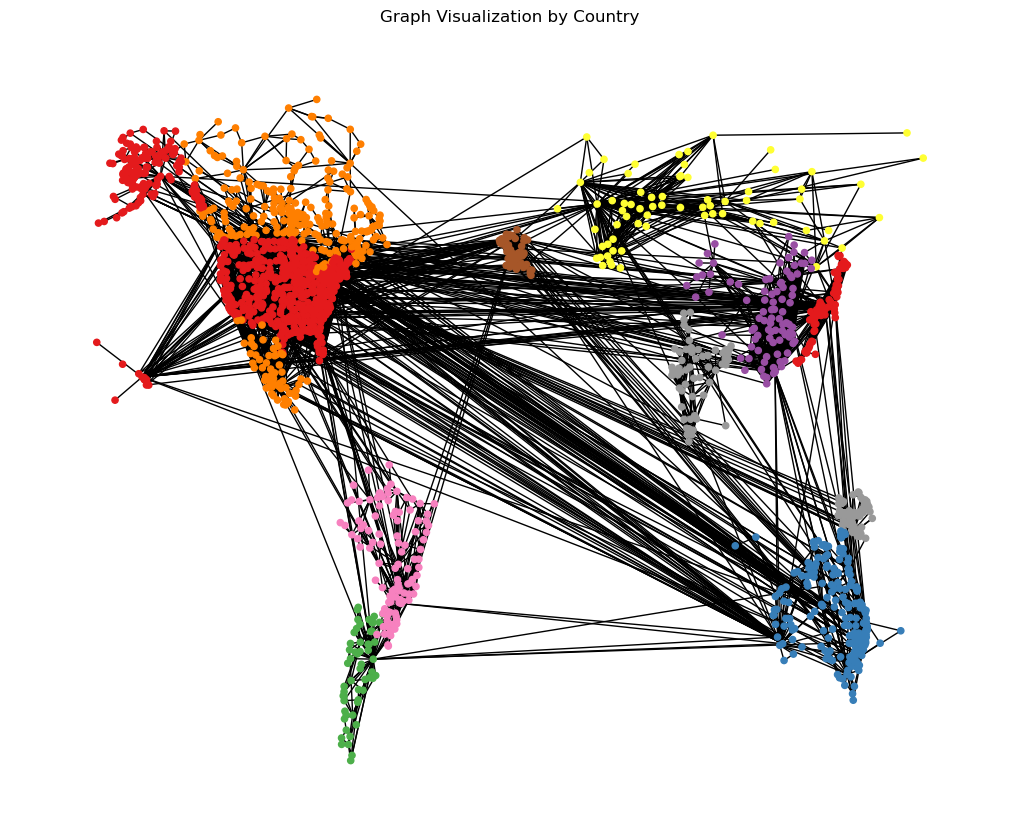

In [6]:
country_counts = {}
for node_id, attributes in G.nodes(data=True):
    country = attributes['country']
    if country in country_counts:
        country_counts[country] += 1
    else:
        country_counts[country] = 1

threshold = 50

countries_to_remove = {country for country, count in country_counts.items() if count < threshold}

for country in countries_to_remove:
    nodes_to_remove = [node_id for node_id, attributes in G.nodes(data=True) if attributes['country'] == country]
    G.remove_nodes_from(nodes_to_remove)

country_colors = {}
for node, attrs in G.nodes(data=True):
    country = attrs['country']
    if country not in country_colors:
        country_colors[country] = len(country_colors) / 10

node_colors = [country_colors[attrs['country']] for _, attrs in G.nodes(data=True)]

# edge_colors = [country_colors[G.nodes[n1]['country']] for n1, n2 in G.edges()]

# Draw the graph
plt.figure(figsize=(10, 8))
pos = {node: (attrs['lon'], attrs['lat']) for node, attrs in G.nodes(data=True)}
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=20, font_size=10, cmap=plt.cm.Set1)
plt.title('Graph Visualization by Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [7]:
import torch_geometric

G.graph = {}
pg = torch_geometric.utils.from_networkx(G, group_node_attrs=["x","y","z"])
pg

Data(edge_index=[2, 11914], lon=[1758], lat=[1758], population=[1758], country=[1758], city_name=[1758], x=[1758, 3])

#### Encoding du label

In [8]:
encoder = LabelEncoder()
int_label = encoder.fit_transform(pg.country)
target_tensor = torch.tensor(int_label, dtype=torch.long)
pg.y = target_tensor
pg.num_classes = len(set(pg.country))

#### Splitting des données

In [9]:
num_nodes = pg.num_nodes
train_ratio = 0.8

mask = torch.rand(num_nodes) < train_ratio
pg.train_mask = mask
pg.test_mask = ~pg.train_mask

temp = torch.zeros((num_nodes, pg.x.shape[-1]), dtype=torch.float)
temp[pg.train_mask] = pg.x[pg.train_mask]
pg.x = temp

In [10]:
pg

Data(edge_index=[2, 11914], lon=[1758], lat=[1758], population=[1758], country=[1758], city_name=[1758], x=[1758, 3], y=[1758], num_classes=12, train_mask=[1758], test_mask=[1758])

### Mise en place et comparaison des modèles

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x
    
class Classifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [12]:
class GNN(torch.nn.Module):

    def __init__(self, num_features, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1, weight_decay=5e-4)
        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            out = self(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

    def evaluate(self, data):
        self.eval()
        pred = self(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        return acc
    
class GNNEncoder(torch.nn.Module):
    def __init__(self, num_features, out_channels, num_classes):
        super().__init__()
        self.encoder = Encoder(num_features, out_channels)
        self.classifier = Classifier(out_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.encoder(x, edge_index)
        x = self.classifier(x)
        return x
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1, weight_decay=5e-4)
        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            out = self(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

    def evaluate(self, data):
        self.eval()
        pred = self(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        return acc
    
    
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_heads, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1, weight_decay=5e-4)
        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            out = self(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

    def evaluate(self, data):
        self.eval()
        pred = self(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        return acc

In [13]:
model1 = GNN(pg.x.shape[1], pg.num_classes)
model1.fit(pg, 5000)
model1.evaluate(pg)

0.8918918918918919

In [14]:
model2 = GNNEncoder(pg.x.shape[1], 16, pg.num_classes)
model2.fit(pg, 5000)
model2.evaluate(pg)

0.8408408408408409

In [15]:
model3 = GAT(pg.x.shape[1], 16, pg.num_classes, 2)
model3.fit(pg, 5000)
model3.evaluate(pg)

0.918918918918919

                      precision    recall  f1-score   support

           ARGENTINA       1.00      0.64      0.78        14
           AUSTRALIA       0.90      0.88      0.89        42
              BRAZIL       1.00      0.96      0.98        28
              CANADA       0.75      0.77      0.76        47
               CHINA       1.00      0.95      0.98        21
              FRANCE       1.00      1.00      1.00        12
               INDIA       1.00      1.00      1.00        10
               JAPAN       1.00      1.00      1.00         7
M&Eacute;XICO#MEXICO       1.00      0.71      0.83         7
    PAPUA_NEW_GUINEA       0.87      0.81      0.84        16
              RUSSIA       0.94      0.89      0.92        19
                 USA       0.86      0.95      0.90       110

            accuracy                           0.89       333
           macro avg       0.94      0.88      0.91       333
        weighted avg       0.90      0.89      0.89       333



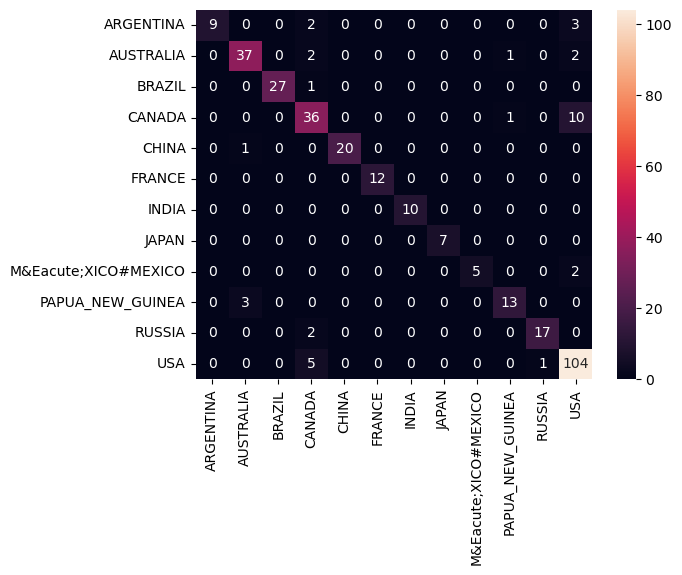

In [16]:
pred1 = model1(pg).argmax(dim=1)

true_labels1 = encoder.inverse_transform(pg.y[pg.test_mask])
predicted_labels1 = encoder.inverse_transform(pred1[pg.test_mask])

print(classification_report(true_labels1, predicted_labels1))

confmat = confusion_matrix(true_labels1, predicted_labels1)
sns.heatmap(confmat, annot=True, fmt='g', xticklabels=encoder.inverse_transform(list(range(12))), yticklabels=encoder.inverse_transform(list(range(12))))
plt.show()

                      precision    recall  f1-score   support

           ARGENTINA       0.43      0.71      0.54        14
           AUSTRALIA       0.65      0.83      0.73        42
              BRAZIL       1.00      0.89      0.94        28
              CANADA       0.84      0.91      0.88        47
               CHINA       0.87      0.95      0.91        21
              FRANCE       1.00      0.67      0.80        12
               INDIA       1.00      1.00      1.00        10
               JAPAN       0.70      1.00      0.82         7
M&Eacute;XICO#MEXICO       1.00      0.71      0.83         7
    PAPUA_NEW_GUINEA       0.91      0.62      0.74        16
              RUSSIA       1.00      0.79      0.88        19
                 USA       0.94      0.84      0.88       110

            accuracy                           0.84       333
           macro avg       0.86      0.83      0.83       333
        weighted avg       0.87      0.84      0.85       333



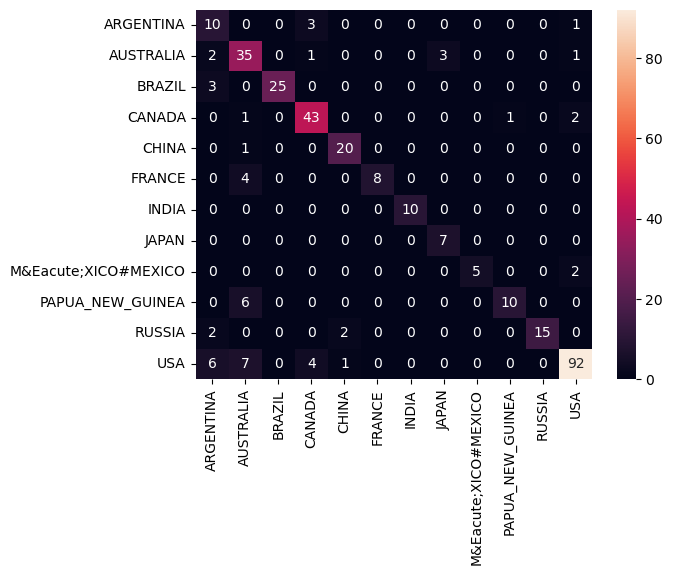

In [17]:
pred2 = model2(pg).argmax(dim=1)

true_labels2 = encoder.inverse_transform(pg.y[pg.test_mask])
predicted_labels2 = encoder.inverse_transform(pred2[pg.test_mask])

print(classification_report(true_labels2, predicted_labels2))

confmat = confusion_matrix(true_labels2, predicted_labels2)
sns.heatmap(confmat, annot=True, fmt='g', xticklabels=encoder.inverse_transform(list(range(12))), yticklabels=encoder.inverse_transform(list(range(12))))
plt.show()

                      precision    recall  f1-score   support

           ARGENTINA       1.00      0.79      0.88        14
           AUSTRALIA       0.86      0.90      0.88        42
              BRAZIL       1.00      0.96      0.98        28
              CANADA       0.90      0.81      0.85        47
               CHINA       1.00      1.00      1.00        21
              FRANCE       1.00      1.00      1.00        12
               INDIA       1.00      1.00      1.00        10
               JAPAN       1.00      0.86      0.92         7
M&Eacute;XICO#MEXICO       1.00      0.86      0.92         7
    PAPUA_NEW_GUINEA       0.92      0.75      0.83        16
              RUSSIA       0.94      0.89      0.92        19
                 USA       0.88      0.98      0.93       110

            accuracy                           0.92       333
           macro avg       0.96      0.90      0.93       333
        weighted avg       0.92      0.92      0.92       333



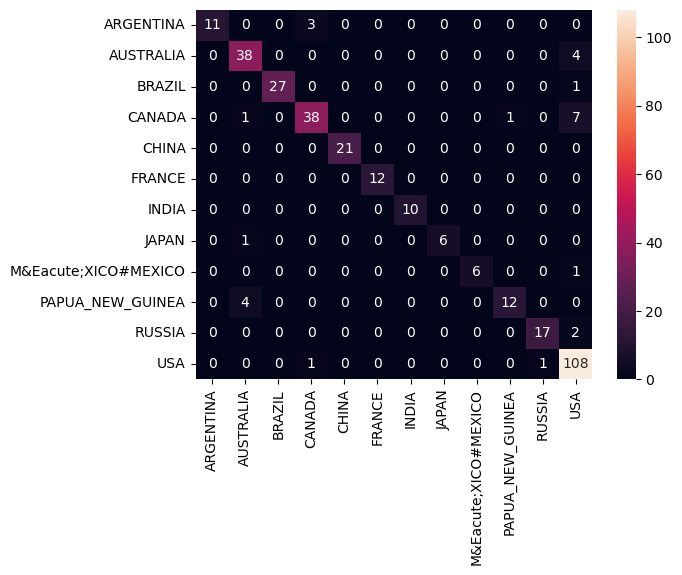

In [18]:
pred3 = model3(pg).argmax(dim=1)

true_labels3 = encoder.inverse_transform(pg.y[pg.test_mask])
predicted_labels3 = encoder.inverse_transform(pred3[pg.test_mask])

print(classification_report(true_labels3, predicted_labels3))

confmat = confusion_matrix(true_labels3, predicted_labels3)
sns.heatmap(confmat, annot=True, fmt='g', xticklabels=encoder.inverse_transform(list(range(12))), yticklabels=encoder.inverse_transform(list(range(12))))
plt.show()

#### Analyse des résultats

Nous allons tenter de voir comment les résultats sont impactés par rapport à l'ensemble de données choisi:
- Réduction du jeu à seulement les 5 pays les plus représentés
- Elargissement au 20 pays les plus représentés

In [19]:
def create_country_subset(graph, limit=5):
    graph_copy = deepcopy(graph)
    counts = {}
    for _, data in graph_copy.nodes(data=True):
        country = data['country']
        if country in counts:
            counts[country] += 1
        else:
            counts[country] = 1
    ordered_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    countries_to_keep = [country[0] for country in ordered_counts[:limit]]
    nodes_to_remove = [node_id for node_id, data in graph_copy.nodes(data=True) if data['country'] not in countries_to_keep]
    for node in nodes_to_remove:
        graph_copy.remove_node(node)
    return graph_copy

def convert_graph_to_geodf(graph):
    cities = []
    countries = []
    latitudes = []
    longitudes = []
    for _, data in graph.nodes(data=True):
        countries.append(data['country'])
        cities.append(data['city_name'])
        latitudes.append(data['lat'])
        longitudes.append(data['lon'])
    df = pd.DataFrame({"Country": countries,"City": cities, "Latitude": latitudes, "Longitude": longitudes})
    return geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

<Axes: >

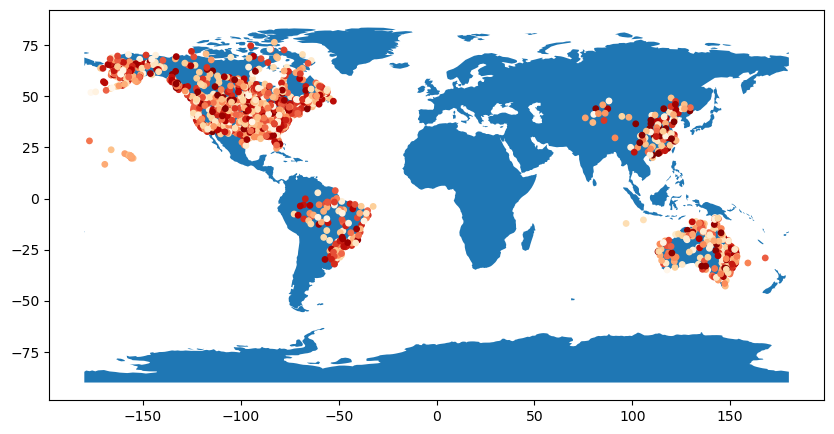

In [20]:
newG = create_country_subset(oldG)

newG.graph = {}
pg = torch_geometric.utils.from_networkx(newG, group_node_attrs=["x","y","z"])

encoder = LabelEncoder()
int_label = encoder.fit_transform(pg.country)
target_tensor = torch.tensor(int_label, dtype=torch.long)
pg.y = target_tensor
pg.num_classes = len(set(pg.country))

num_nodes = pg.num_nodes
train_ratio = 0.8
mask = torch.rand(num_nodes) < train_ratio
pg.train_mask = mask
pg.test_mask = ~pg.train_mask
temp = torch.zeros((num_nodes, pg.x.shape[-1]), dtype=torch.float)
temp[pg.train_mask] = pg.x[pg.train_mask]
pg.x = temp

geodf = convert_graph_to_geodf(newG)
world = geopandas.read_file(geodatasets.data.naturalearth.land['url'])
geodf.plot(ax=world.plot(figsize=(10, 6)), marker='o', markersize=15, column='City', cmap='OrRd')

In [21]:
model = GAT(pg.x.shape[1], 16, pg.num_classes, 2)
model.fit(pg, 100)
model.evaluate(pg)

pred = model(pg).argmax(dim=1)

true_labels = encoder.inverse_transform(pg.y[pg.test_mask])
predicted_labels = encoder.inverse_transform(pred[pg.test_mask])

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

   AUSTRALIA       1.00      0.79      0.88        48
      BRAZIL       1.00      0.89      0.94        27
      CANADA       0.96      0.72      0.82        67
       CHINA       0.72      1.00      0.84        21
         USA       0.84      0.98      0.91       129

    accuracy                           0.88       292
   macro avg       0.91      0.88      0.88       292
weighted avg       0.90      0.88      0.88       292



The average percentage of neighbors in USA is 0.9611961577139808 and the percentage of neighbors outside is 0.03880384228601927
The average percentage of neighbors of neighbors in USA is 0.9272567057504454 and the percentage of neighbors outside is 0.07274329424955464


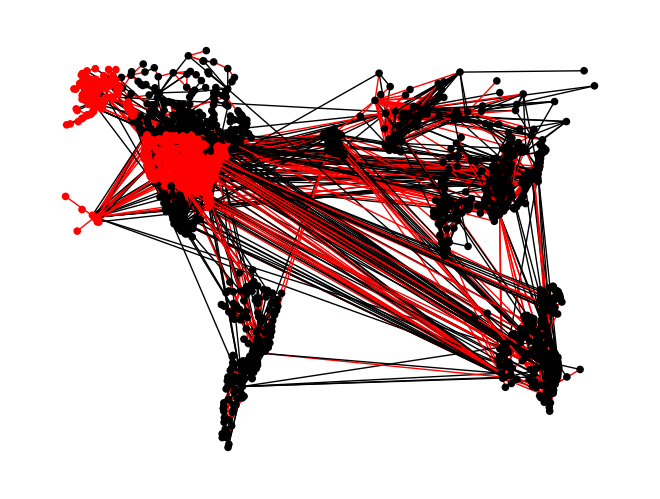

The average percentage of neighbors in CHINA is 0.9766484018317234 and the percentage of neighbors outside is 0.02335159816827655
The average percentage of neighbors of neighbors in CHINA is 0.835603992050997 and the percentage of neighbors outside is 0.16439600794900283


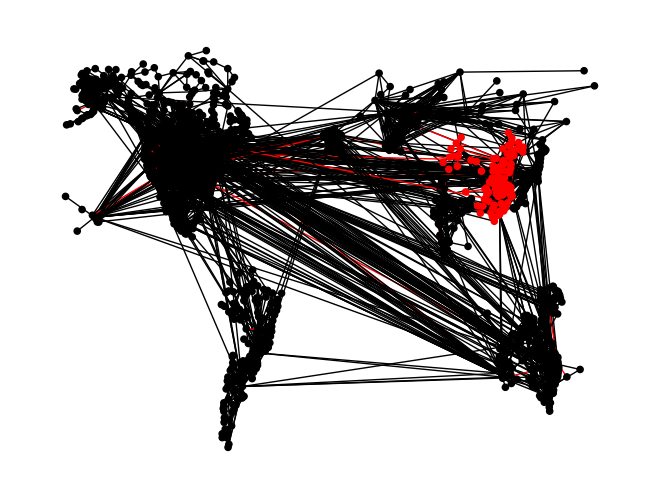

In [22]:
def draw_with_focus_on_country(country):
    node_colors = ['red' if G.nodes[n].get('country') == country else 'black' for n in G.nodes()]
    pos = {node: (attrs['lon'], attrs['lat']) for node, attrs in G.nodes(data=True)}
    same, others = get_avg_similar_neighbors_stats(country)
    same2, others2 = get_avg_similar_neighbors_of_neighbors_stats(country)
    print(f"The average percentage of neighbors in {country} is {same} and the percentage of neighbors outside is {others}")
    print(f"The average percentage of neighbors of neighbors in {country} is {same2} and the percentage of neighbors outside is {others2}")
    nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color=node_colors, node_size=20, font_size=10, cmap=plt.cm.Set1)
    plt.show()

def get_avg_similar_neighbors_stats(country):
    nodes_with_specific_attr = [node for node, data in G.nodes(data=True) if data['country'] == country]
    same_list = []
    others_list = []
    for node in nodes_with_specific_attr:
        same = 0
        others = 0
        count = 0
        for id in nx.all_neighbors(G, node):
            count += 1
            if G.nodes[id]['country'] == country:
                same += 1
            else:
                others += 1
        if count > 0:
            same_list.append(same/count)
            others_list.append(others/count)
    same_np, others_np = np.array(same_list), np.array(others_list)
    return same_np.mean(), others_np.mean()

def get_avg_similar_neighbors_of_neighbors_stats(country):
    nodes_with_specific_attr = [node for node, data in G.nodes(data=True) if data['country'] == country]
    same_list = []
    others_list = []
    for node in nodes_with_specific_attr:
        same = 0
        others = 0
        count = 0
        for id in nx.all_neighbors(G, node):
            for idj in nx.all_neighbors(G, id):
                count += 1
                if G.nodes[id]['country'] == country:
                    same += 1
                else:
                    others += 1
            if count > 0:
                same_list.append(same/count)
                others_list.append(others/count)
    return np.array(same_list).mean(), np.array(others_list).mean()

draw_with_focus_on_country("USA")
draw_with_focus_on_country("CHINA")

The average percentage of neighbors in M&Eacute;XICO#MEXICO is 0.7782332973408487 and the percentage of neighbors outside is 0.22176670265915116
The average percentage of neighbors of neighbors in M&Eacute;XICO#MEXICO is 0.3175139062748849 and the percentage of neighbors outside is 0.682486093725115


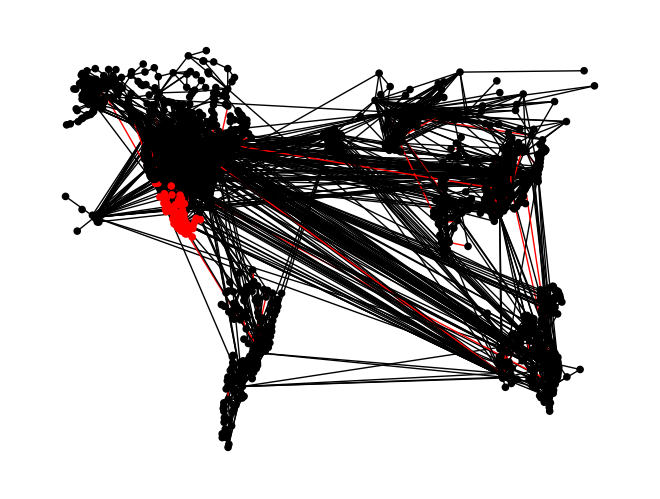

The average percentage of neighbors in JAPAN is 0.9463440485421367 and the percentage of neighbors outside is 0.05365595145786332
The average percentage of neighbors of neighbors in JAPAN is 0.6274532964129237 and the percentage of neighbors outside is 0.3725467035870763


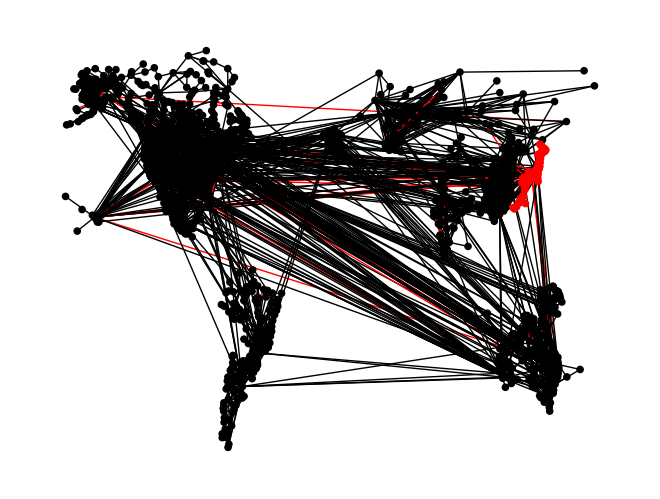

The average percentage of neighbors in ARGENTINA is 0.9932586094866797 and the percentage of neighbors outside is 0.0067413905133203375
The average percentage of neighbors of neighbors in ARGENTINA is 0.7669050293434648 and the percentage of neighbors outside is 0.23309497065653514


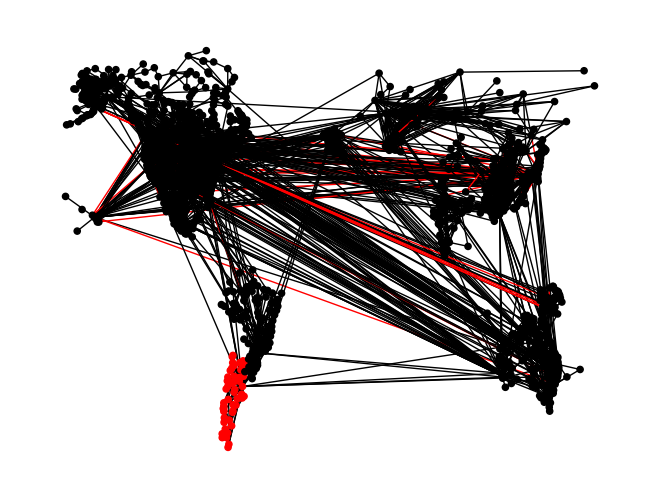

In [23]:
draw_with_focus_on_country("M&Eacute;XICO#MEXICO")
draw_with_focus_on_country("JAPAN")
draw_with_focus_on_country("ARGENTINA")

### Ablation Study

#### Réduction de la complexité du modèle

In [24]:
class GATTest1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes, dropout=0.5):
        super().__init__()
        self.conv = GATConv(num_features, num_classes, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return x
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1, weight_decay=5e-4)
        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            out = self(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

    def evaluate(self, data):
        self.eval()
        pred = self(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        return acc

In [25]:
model = GATTest1Layer(pg.x.shape[1], pg.num_classes)
model.fit(pg, 100)
model.evaluate(pg)

pred = model(pg).argmax(dim=1)

true_labels = encoder.inverse_transform(pg.y[pg.test_mask])
predicted_labels = encoder.inverse_transform(pred[pg.test_mask])

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

   AUSTRALIA       0.95      0.75      0.84        48
      BRAZIL       1.00      0.33      0.50        27
      CANADA       1.00      0.15      0.26        67
       CHINA       0.69      0.86      0.77        21
         USA       0.61      0.99      0.76       129

    accuracy                           0.69       292
   macro avg       0.85      0.62      0.62       292
weighted avg       0.80      0.69      0.63       292



#### Test sans transformation des données

In [26]:
G.graph = {}
pg = torch_geometric.utils.from_networkx(G, group_node_attrs=["lat","lon"])

encoder = LabelEncoder()
int_label = encoder.fit_transform(pg.country)
target_tensor = torch.tensor(int_label, dtype=torch.long)
pg.y = target_tensor
pg.num_classes = len(set(pg.country))

num_nodes = pg.num_nodes
train_ratio = 0.8

mask = torch.rand(num_nodes) < train_ratio
pg.train_mask = mask
pg.test_mask = ~pg.train_mask

temp = torch.zeros((num_nodes, pg.x.shape[-1]), dtype=torch.float)
temp[pg.train_mask] = pg.x[pg.train_mask]
pg.x = temp

model = GAT(pg.x.shape[1], 16, pg.num_classes, 2)
model.fit(pg, 100)
model.evaluate(pg)

pred = model(pg).argmax(dim=1)

true_labels = encoder.inverse_transform(pg.y[pg.test_mask])
predicted_labels = encoder.inverse_transform(pred[pg.test_mask])

print(classification_report(true_labels, predicted_labels))

                      precision    recall  f1-score   support

           ARGENTINA       0.92      0.79      0.85        14
           AUSTRALIA       0.93      0.59      0.72        46
              BRAZIL       0.95      0.90      0.92        20
              CANADA       0.81      0.78      0.80        55
               CHINA       0.00      0.00      0.00        19
              FRANCE       0.85      1.00      0.92        11
               INDIA       1.00      0.13      0.24        15
               JAPAN       0.38      0.50      0.43        18
M&Eacute;XICO#MEXICO       0.00      0.00      0.00        24
    PAPUA_NEW_GUINEA       0.33      0.82      0.47        17
              RUSSIA       0.55      0.67      0.60         9
                 USA       0.67      0.90      0.77       126

            accuracy                           0.68       374
           macro avg       0.62      0.59      0.56       374
        weighted avg       0.66      0.68      0.64       374



#### Test sans suppression de pays

In [27]:
oldG.graph = {}
pg = torch_geometric.utils.from_networkx(oldG, group_node_attrs=["x","y","z"])

encoder = LabelEncoder()
int_label = encoder.fit_transform(pg.country)
target_tensor = torch.tensor(int_label, dtype=torch.long)
pg.y = target_tensor
pg.num_classes = len(set(pg.country))

num_nodes = pg.num_nodes
train_ratio = 0.8

mask = torch.rand(num_nodes) < train_ratio
pg.train_mask = mask
pg.test_mask = ~pg.train_mask

temp = torch.zeros((num_nodes, pg.x.shape[-1]), dtype=torch.float)
temp[pg.train_mask] = pg.x[pg.train_mask]
pg.x = temp

model = GAT(pg.x.shape[1], 16, pg.num_classes, 2)
model.fit(pg, 100)
model.evaluate(pg)

pred = model(pg).argmax(dim=1)

true_labels = encoder.inverse_transform(pg.y[pg.test_mask])
predicted_labels = encoder.inverse_transform(pred[pg.test_mask])

print(classification_report(true_labels, predicted_labels))

                                                                precision    recall  f1-score   support

                                                       ALGERIA       0.00      0.00      0.00         5
                                                        ANGOLA       0.00      0.00      0.00         1
                                                     ARGENTINA       1.00      0.50      0.67         6
                                                     AUSTRALIA       0.53      0.83      0.65        29
                                                       AUSTRIA       0.00      0.00      0.00         1
                                                       BAHAMAS       0.00      0.00      0.00         2
                                                    BANGLADESH       0.00      0.00      0.00         2
                                                       BELGIUM       0.00      0.00      0.00         1
                                                       BOLIVIA 